# The Detection of Deep-fakes Through Corneal Reflections: A Feasibility Study
<b>Sarah Barrington, November 2022</b>

---------------------------------------------------------------------------------
# Introduction

Classical computer science techniques for the re- projection of an image onto a non-planar surface have been extended to modelling the geometry of the human eye, as seen in Ko and Nayar (2004)(1). Yet, there are few examples of the application of these methods to the analysis of corneal reflections in deep fake detection. The work of Hu et al. (2021)(2) explored inconsistencies in inter-eye reflections, but focussed solely on specular highlights as opposed to the reflected scene itself. This work aims to build upon these two approaches in order to investigate whether there are discernible differences between the corneal reflections of real vs. deep-fake human portraits. 

### Findings
    
The findings from this approach provide several key contributions:
    
* A framework for automatically extracting the corneal surface of a human in a single image and generating iris-based features. 

* For two publicly-available datasets, we ultimately find that there are no significant discernible differences between real and fake corenal reflections (based upon the performance of three classification models).  

* We hypothesise that this lack of differentiation between real and fake portraits is primarily due to insufficient image quality once cropped (which typically reduces a 1024x1024px photo down to approximately 50x50px). This clearly impacts the pixel representation of the corneal surface and introduces noise that distorts the extracted features. The noisy nature of the dataset is evident from the outputs of Principal Component Analysis, which indicates that 10 components are required to capture just 75% of the variation in the data.

* In spite of this, the feature extraction process highlights several features of interest that, qualitatively, can be seen to differentiate between real and fake portraits. This includes the shape of the pupil, which, for the majority of humans, should form a near-perfect circle shape when facing toward the camera. Yet, in several GAN-synthesised images from our dataset, we observe inconsistencies such as straight edges, corners, and even no clear pupil at all. 

* Additionally, edges observed in the reflections of real corneal surfaces (particularly in outdoor or natural light settings) exhibit discernable properties such as objects or information about the scene. By contrast, several deep-fake corneal reflections were observed to contain noise and abstract lighting, not resembling a coherent scene or object. However, we hypotheise that while evident to a human, the edge count feature was skewed by noise in the low resolution cropped images, thus not providing a strong predictor. 

## Assumptions and Limitations
During the data acquisition and processing stages, several assumptions were noted that underpinned the subsequent analysis. Firstly, the subject of all potraits needed to be looking forward towards the camera with a visible eye. Ultimately, any cases in which this was not the case were removed. Secondly, the creation process of fake portraits from thispersondoesnotexist.com uses StyleGAN 2(3), and so all findings relating to feature prediction power and classification relate only to this singular generation algorithm. Both real and fake datasets provide images of 1024x1024px, ensuring consistent resolution across both real and fake data.

The limitations of this approach stem mainly from the use of two public datasets. The 1024px size of image is deemed high quality for the generation and detection of full facial features. Yet at the corneal level, we face a significant reduction in image size and thus quality, ultimately impacting the overall prediction power of a model trained on this data. Similarly, there are inherent limitations in the use of open source deep-learning frameworks for xtraction of facial landmarks. Often the corneal key points that were extracted were not fully accurate against the image, often including the whites of the eyes or part of the eyelid. To control for this, a manual data cleaning approach was used to discard failure cases from the training sample. This remains similar across other packages, such as DLib, which provided similar results and failure cases. 

## Further Work 
Further work would primarily focus on these limitations. In particular, a higher-resolution input dataset for the real faces should be identified or created in a laboratory setting in order to examine higher-quality corneal images. This would also be true of the generated images, which would need to be trained and re-calibrated to produce higher resolution outputs. Secondly, we would seek to expand the fake dataset to other types of creation algorithms, including the original styleGAN algorithm and diffusion-based models. 

Additionally, the features extracted are exploratory, and require further refining in order to improve classifer performance on a higher quality input dataset. 

## References
(1) Nishino, Ko, and Shree K. Nayar. "The world in an eye [eye image interpretation]." Proceedings of the 2004 IEEE Computer Society Conference on Computer Vision and Pattern Recognition, 2004. CVPR 2004.. Vol. 1. IEEE, 2004.  
(2) S. Hu, Y. Li and S. Lyu, "Exposing GAN-Generated Faces Using Inconsistent Corneal Specular Highlights," ICASSP 2021 - 2021 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP), 2021, pp. 2500-2504, doi: 10.1109/ICASSP39728.2021.9414582.  
(3) StyleGAN2 (Dec 2019) - Karras et al. and Nvidia

---------------------------------------------------------------------------------


# Dataset

The dataset used for this project is a combination of contain both real and fake portraits from two publicly-available datasets:

* Flickr-faces High Quality (FFHQ) - https://github.com/NVlabs/ffhq-dataset
* This Person Does Not Exist (TPDNE) - https://thispersondoesnotexist.com/

The data was downloaded from the FFHQ GitHub source repository and an open source TPDNE scraping API (found here: https://github.com/makeev/ThisPersonDoesNotExistAPI). 

## Data Engineering


Both datasets have high image availability, with FFHQ containing <b>70,000</b> portraits and TPDNE providing an indefinite number of novel GAN-based facial generations. Due to the exploratory nature of this project, alongside computational limits, a sample of 1,000 images was extracted from each of the datasets, resulting in a <b>2,000</b> overall sample size equally balanced across real and fake labelled portraits. 

The samples were created using a proprietary script. For the purposes of this project, the original 70,000 image repository and sample creation process have not been included in this notebook. 

## Manual Processing
Having obtained the sample, the corneal region of interest was extracted from each photo. Once complete, a manual process was used to detect 'failure cases'. These were decided based upon a heuristic of the iris covering <50% of the photo, . These failure cases were then discarded from the input datasets. The dataset lengths were matched to the minimum of the real and fake datasets, resulting in a final sample size of <b>832 images</b> (416 real and 416 fake).

## Data Availability
A folder (called <b>'test_images'</b>) has been included with this submission in order to illustrate key features and facilitate the model training process. 

# Sample Pre-Processing
Having obtained the samples of 1000 real and 1000 fake images in a prior script, the pre-processing begins with the detection and extraction of the corneal surface. An example is illustrated below. 

In [1]:
import os
import cv2
import shutil
import dlib
import face_alignment
import collections

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from ipywidgets import IntProgress
from IPython.display import display
from skimage import io, feature, transform
from tqdm import tqdm
from sklearn import decomposition, preprocessing, manifold, linear_model, svm, model_selection, metrics

In [2]:
# Initial test case
test_img = io.imread('test_images/real_full_face_00015.png')

# Image checks
img = test_img
print(f'Number of color channels: {img.shape[2]}')
print(f'Size of photo: {img.shape[1]} x {img.shape[0]}')

Number of color channels: 3
Size of photo: 1024 x 1024


## Facial Landmarks
Each face (both real and fake) is ingested as a 1024x1024 color image with 3 channels (R,G,B). Where necessary for subsequent analysis, images are converted to single channel grayscale.   
The below approach uses the face_alignment package and plots from the source code found at: https://github.com/1adrianb/face-alignment/blob/master/examples/detect_landmarks_in_image.py

## Extraction of Facial Landmarks via face_alignment

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


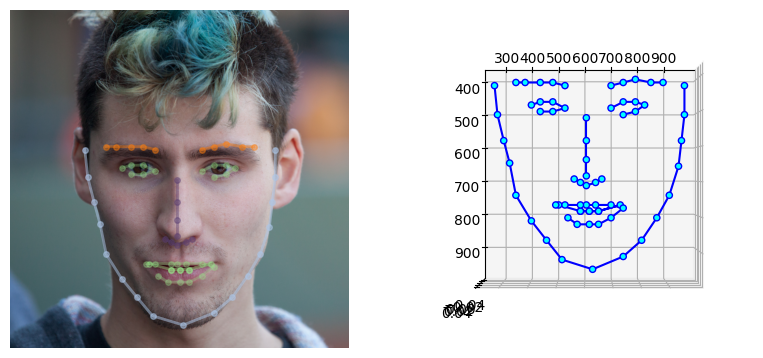

In [3]:
# Set up input parameters for face alignment
face_detector = 'sfd'
face_detector_kwargs = {"filter_threshold" : 0.8}

# Instantiate alignment model
fa  = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, device='cpu', flip_input=True,
                                  face_detector=face_detector, face_detector_kwargs=face_detector_kwargs)

# Obtain landmarks
input_img = img
preds = fa.get_landmarks(input_img)[-1]

# Poduce plot - as per exampels code from face_alignment docs
plot_style = dict(marker='o',
                  markersize=4,
                  linestyle='-',
                  lw=2)

pred_type = collections.namedtuple('prediction_type', ['slice', 'color'])
pred_types = {'face': pred_type(slice(0, 17), (0.682, 0.780, 0.909, 0.5)),
              'eyebrow1': pred_type(slice(17, 22), (1.0, 0.498, 0.055, 0.4)),
              'eyebrow2': pred_type(slice(22, 27), (1.0, 0.498, 0.055, 0.4)),
              'nose': pred_type(slice(27, 31), (0.345, 0.239, 0.443, 0.4)),
              'nostril': pred_type(slice(31, 36), (0.345, 0.239, 0.443, 0.4)),
              'eye1': pred_type(slice(36, 42), (0.596, 0.875, 0.541, 0.3)),
              'eye2': pred_type(slice(42, 48), (0.596, 0.875, 0.541, 0.3)),
              'lips': pred_type(slice(48, 60), (0.596, 0.875, 0.541, 0.3)),
              'teeth': pred_type(slice(60, 68), (0.596, 0.875, 0.541, 0.4))
              }

fig = plt.figure(figsize=plt.figaspect(.5))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(input_img)

for pred_type in pred_types.values():
    ax.plot(preds[pred_type.slice, 0],
            preds[pred_type.slice, 1],
            color=pred_type.color, **plot_style)

ax.axis('off')

# 3D-Plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax.scatter(preds[:, 0] * 1.2,
                  preds[:, 1],
                  c='cyan',
                  alpha=1.0,
                  edgecolor='b')

for pred_type in pred_types.values():
    ax.plot3D(preds[pred_type.slice, 0] * 1.2,
              preds[pred_type.slice, 1], color='blue')

ax.view_init(elev=90., azim=90.)
ax.set_xlim(ax.get_xlim()[::-1])
plt.show()

## Fitting Circle to Iris on Corneal Surface Keypoints
The prior work of Ko & Nayar(1) proved that the visible surface of the eye can be modelled as a spherical segment with a 120 degree field of view (FOV) for a typical human. An illustration of the resulting iris cross section is illustrated below. 

As such, the irises can be extracted as circular pixel regions within the image, provided that the subject is looking forward into the camera (as discussed previously in the 'assumptions' section above). 
Shree paper, Hany's code to find circle


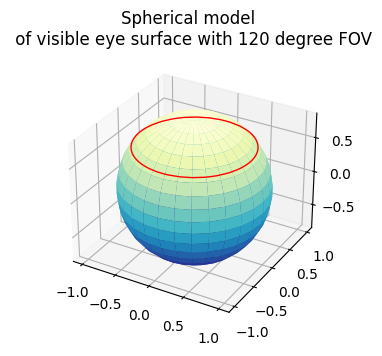

In [4]:
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Circle

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
r = 0.05

u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)

# FOV

ax.plot_surface(x, y, z, cmap=plt.cm.YlGnBu_r)

p = Circle((0, 0), 0.8, color='red', fill=False)
ax.add_patch(p)
art3d.pathpatch_2d_to_3d(p, z=0.6, zdir="z")

ax.set_aspect('equal')
ax.set_title('Spherical model \n of visible eye surface with 120 degree FOV')

plt.show()
ax.scatter(0,0,0)
plt.show()

A circle is thus fit to the resulting facial landmarks corresponding to the left and right eyes (keypoints 37,38, 40, 41, 43, 44, 46 and 47). Note that only the left eye is used for feature extraction and model training. The iris surfaces are shown in orange (left) and blue (right) below.

(634, 487, 25)
(384, 484, 24)


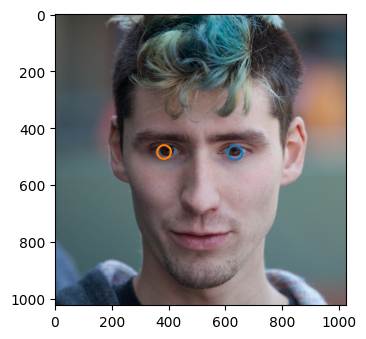

In [5]:
def fit_circle(key_points): 
    
    # Least squares fitting
    n  = len(key_points) 
    M  = np.vstack((key_points[:,0],key_points[:,1],np.ones((4)))).T
    b  = np.array([key_points[:,0]*key_points[:,0] + key_points[:,1]*key_points[:,1]]).T
    u  = np.linalg.pinv(M)@b
    
    # Obtain center (cx, cy) and radius (r)
    cx = u[0]/2
    cy = u[1]/2
    r  = np.sqrt(4*u[2] + u[0]*u[0] + u[1]*u[1])/2
    
    return round(cx[0]), round(cy[0]), round(r[0])

preds = fa.get_landmarks(img)
if preds is not None: 
    
    # Ensure only one face is found
     if len(preds) == 1:
            preds = preds[0]
            
            # fit circles to left/right eye landmarks
            eyeL  = fit_circle(preds[[37,38,40,41],:])
            irisL = img[eyeL[1]-eyeL[2]:eyeL[1]+eyeL[2], eyeL[0]-eyeL[2]:eyeL[0]+eyeL[2],:]
            eyeR  = fit_circle(preds[[43,44,46,47],:])
            irisR = img[eyeR[1]-eyeR[2]:eyeR[1]+eyeR[2], eyeR[0]-eyeR[2]:eyeR[0]+eyeR[2],:]

# Create fig to visually check circle is initialising correctly
plt.imshow(input_img, cmap='gray')

# Generate theta values for circle points - for plotting purposes only 
theta = np.linspace(0, 2*np.pi, 100)
eyes = [eyeR, eyeL]

for eye in eyes:
    print(eye)

    cx = eye[0]
    cy = eye[1]
    r = eye[2]

    # Use parametric equation of a circle to overlay plot
    x = cx + r*np.cos(theta)
    y = cy + r*np.sin(theta)

    plt.plot(x, y)

## Extracting Iris Only
The circular region detected by the prior steps is then cropped from the original image to create a corneal-only dataset.

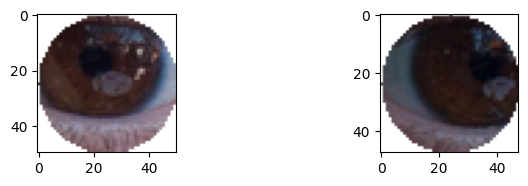

In [6]:
counter = 1
for eye in eyes:

    cx = eye[0]
    cy = eye[1]
    r = eye[2]

    mask = np.zeros_like(img)
    mask = cv2.circle(mask, (cx,cy), r, (255,255,255), -1)

    result = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
    result[:, :, 3] = mask[:,:,0]
    
    # Take all non-white values and make larger 
    is_ = []
    js_ = []

    for i in range(0, len(result)):
        for j in range(0, len(result[i])):
            if result[i][j][3] > 0: # If non-transaprent
                is_.append(i)
                js_.append(j)
    # Return only crop
    crop_boundary = result[np.min(is_):np.max(is_), np.min(js_):np.max(js_)]
    plt.subplot(2, 2, counter)
    plt.imshow(crop_boundary) 
    counter = counter + 1

### Face Alignment vs. DLib Implementation
Additionally, the DLib package was used to explore improvements to the detection of the corneal keypoints. However, the two packages were found to perform similarly, with many cases incorporating some of the eyelid or whites of eyes. 

## Run Pre-Processing Pipeline

The above pipeline was then run on all 2,000 sample images, resulting in 2,000 corneal surface images (using the left eye only for each image subject). Failure cases containing < 50% iris coverage were then manually removed from the dataset as described above, resulting in a total sample size of 832 images. 

# Feature Extraction
    
The aim of this project was to examine corneal reflections and other features that may be indicative of real vs. fake human portraits. As such, the following features were extracted:
- n_circles - the number of circles detected within the extracted region, with a maximum of 1 pertaining to a circular pupil (qualitatively, several GAN images contained non-circular or non-visible pupils). 
- specular_pixels - the number of pixels pertaining to specular highlights, which as deduced using a simplified assumption that these pixels would have a brightness greater than a near-white threshold (int his case, 215, as observed as best performing on a sample of input images). 
- mean intensities, reds, greens, blues - channel intensities of the iris surface only, examining whether any dominant or non-typical colours emerged in the reflections. 
- edges - the number of edge pixels detected on the corneal surface.
- hog_pixels - the number of pixels extracted pertaining to a pixel detected within the Histogram of Oriented Gradients, indicating changes in surface vectors of the cornea. 
- pc_1, pc_2 - first two principal components extracted from the overall dataset, accounting for 45% of variation in the dataset.

Example outputs are indicated below. 

## Data Ingestion

In [7]:
# Ingest data
real_path = 'test_images/ffhq_passes/'
fake_path = 'test_images/tpdne_passes/'

real = [io.imread(real_path + file) for file in os.listdir(real_path) if not file.startswith('.')]
fake = [io.imread(fake_path + file) for file in os.listdir(fake_path) if not file.startswith('.')]

print(len(real))
print(len(fake))

# Subset real and fake data to match min length of passed samples
min_ = np.min([len(real), len(fake)])
real = real[:min_]
fake = fake[:min_]
print(len(real))
print(len(fake))

real_grays = [cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY) for image in real]
fake_grays = [cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY) for image in fake]

416
715
416
416


In [8]:
# Create features dataframe to hold all extraction outputs
labels_real = [0 for image in real_grays]
labels_fake = [1 for image in fake_grays]

feature_vectors = pd.DataFrame({'image_id':[i for i in range(len(real_grays + fake_grays))]})
feature_vectors['label'] = [item for item in (labels_real + labels_fake)]

### Non-Circular Pupils
Using a hough transform to detect circles within the image, after having applied a blur filter. 

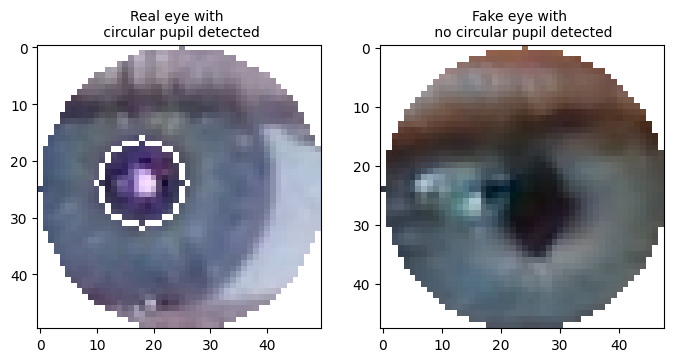

832


In [9]:
def extract_circular_pupil(image):
    # Blur image
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_blur = cv2.medianBlur(gray_image, 5)

    # Hough circle transform
    rows = gray_blur.shape[0]
    circles = cv2.HoughCircles(gray_blur, cv2.HOUGH_GRADIENT, 1, rows / 8,
                               param1=100, param2=30,
                               minRadius=1, maxRadius=30)

    if circles is not None:
        circles = np.uint16(np.around(circles))
        for circle in circles[0, :]:
            center = (circle[0], circle[1])
            radius = circle[2]
            cv2.circle(image, center, radius, (0, 0, 255), 1)

        return image, len(circles)
    
    else:
        
        return image, 0
    
example_image = io.imread('test_images/real_eye_42074_cropped_l.png')
fake_example_image = io.imread('test_images/fake_eye_36a3794175aef57e882a7a268cbc0231_cropped_l.png')

fig, ax = plt.subplots(1, 2)
ax[0].imshow(extract_circular_pupil(example_image)[0])
ax[0].set_title('Real eye with \n circular pupil detected', fontsize=10)
ax[1].imshow(extract_circular_pupil(fake_example_image)[0])
ax[1].set_title('Fake eye with \n no circular pupil detected', fontsize=10)
plt.show()

n_circles = []

for image in real+fake:
    n_circles.append(extract_circular_pupil(image)[1]) 
print(len(n_circles))

## Histogram and channel intensities

### Visually explore histogram

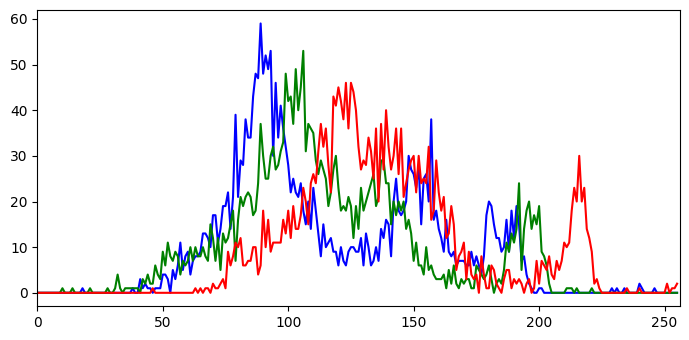

In [10]:
example_image = io.imread('test_images/real_eye_42074_cropped_l.png')
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([example_image],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

### Use threshold to remove peripheral eye whites

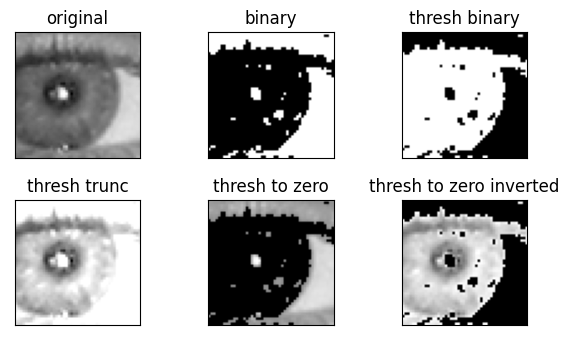

In [11]:
gray_image = cv2.cvtColor(example_image,cv2.COLOR_BGR2GRAY)

ret,thresh_binary = cv2.threshold(gray_image,127,255,cv2.THRESH_BINARY)
ret,thresh_binary_inv = cv2.threshold(gray_image,127,255,cv2.THRESH_BINARY_INV)
ret,thresh_trunc = cv2.threshold(gray_image,127,255,cv2.THRESH_TRUNC)
ret,thresh_tozero = cv2.threshold(gray_image,127,255,cv2.THRESH_TOZERO)
ret,thresh_tozero_inv = cv2.threshold(gray_image,127,255,cv2.THRESH_TOZERO_INV)
 
names = ['original','binary','thresh binary','thresh trunc','thresh to zero','thresh to zero inverted']
 
images = gray_image,thresh_binary,thresh_binary_inv,thresh_trunc,thresh_tozero,thresh_tozero_inv
 
for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
    plt.title(names[i])
    plt.xticks([]),plt.yticks([])

### Extract colours and intensities from iris reflections

In [12]:
# Select only iris and take average RGB and luminance
intensities = []
reds = []
blues = []
greens = []
all_ = real+fake

for image in all_:
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    
    thresh_tozero_inv = cv2.threshold(gray,127,255,cv2.THRESH_TOZERO_INV)
    non_zeroes = np.where(thresh_tozero_inv[1]>0)
    
    intensities.append(np.mean(gray[non_zeroes]))
    reds.append(np.mean(image[:, :, 0][non_zeroes]))
    greens.append(np.mean(image[:, :, 1][non_zeroes]))
    blues.append(np.mean(image[:, :, 2][non_zeroes]))

## Number of Edges
A canny edge detector is used to extract all edges within the cropped image. Note: the crop surface is also detected within this, however, this is the same for all input photos. As such, a key assumption of the edge detection method is that the inclusion of the crop edge does not impact analysis. 

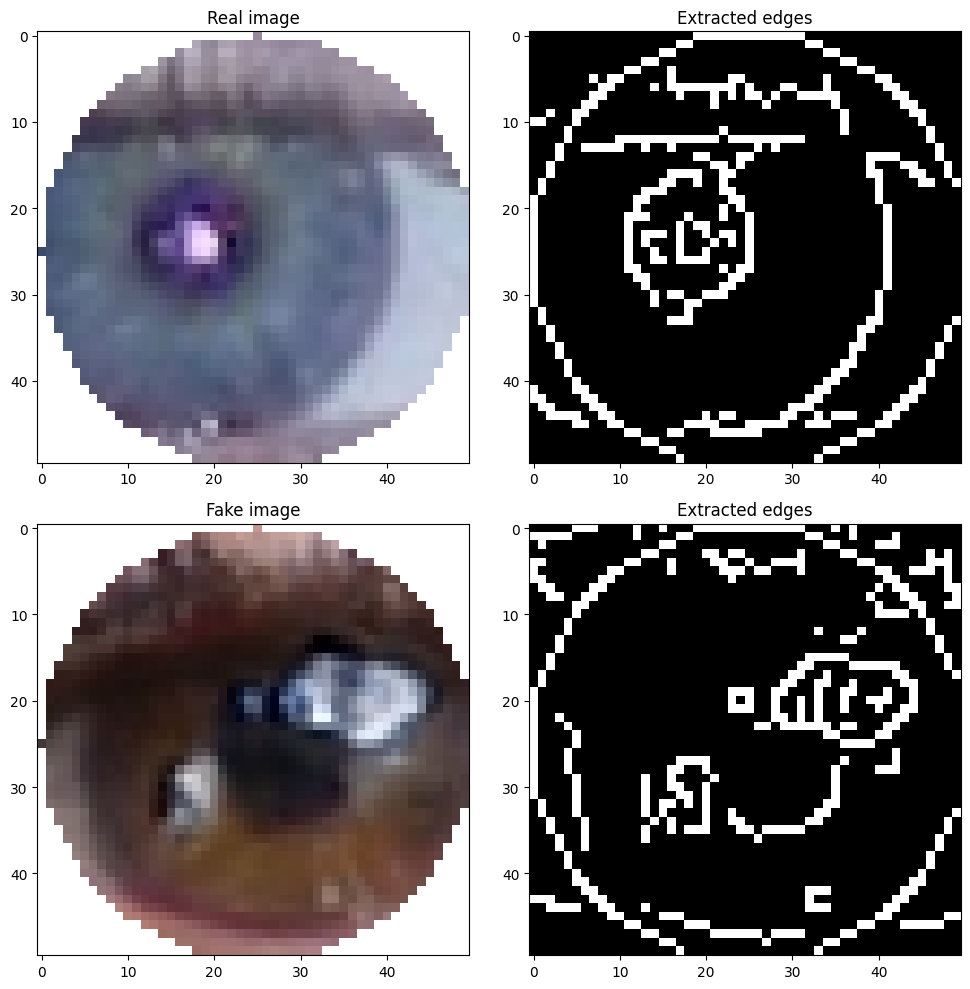

832


In [13]:
example_image = io.imread('test_images/real_eye_42074_cropped_l.png')
edges_of_image = cv2.Canny(example_image,100,200) 

fake_example_image = io.imread('test_images/00243bf41d128f793aece3d636a29975_cropped_l.png')
fake_edges = cv2.Canny(fake_example_image,100,200) 

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(example_image, cmap='gray')
ax[0, 0].set_title('Real image')
ax[0, 1].imshow(edges_of_image, cmap='gray')
ax[0, 1].set_title('Extracted edges')

ax[1, 0].imshow(fake_example_image, cmap='gray')
ax[1, 0].set_title('Fake image')
ax[1, 1].imshow(fake_edges, cmap='gray')
ax[1, 1].set_title('Extracted edges')
plt.show()

edges = []

for image in real_grays+fake_grays:
    edges_of_image = cv2.Canny(image,100,200) 
    edges.append(len(edges_of_image[edges_of_image>0]))
print(len(edges))

## Histogram of Oriented Gradients
HOG is extracted using the skimage hog function to detect distinct visual features of the corneal surface.

832


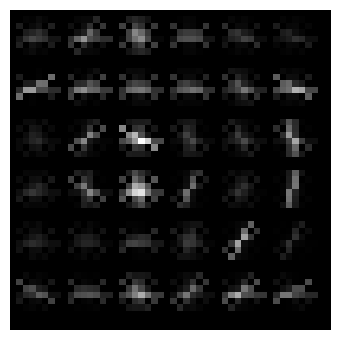

In [14]:
example_image = io.imread('test_images/real_eye_42074_cropped_l.png')
gray_image = cv2.cvtColor(example_image, cv2.COLOR_BGR2GRAY)
fd, hog_image = feature.hog(gray_image, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True)
plt.axis("off")
plt.imshow(hog_image, cmap="gray")

hog_pixels = []

for image in real_grays+fake_grays:
    hog_pixels.append(len(image[image>0]))
print(len(hog_pixels))

## Specular Highlights
A simplified version of the work by Hu. et al, using a luminance threshold. 

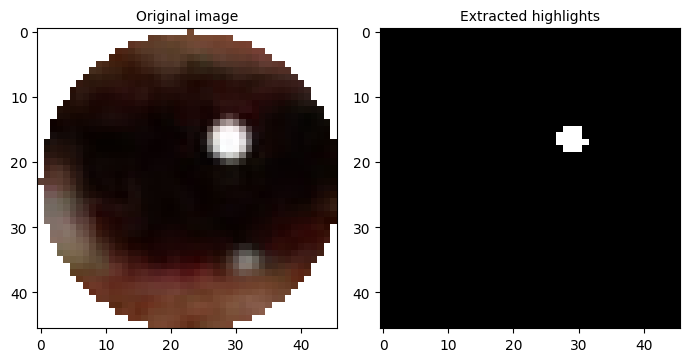

832


In [15]:
threshold = 215
specular_pixels = []

example_image = io.imread('test_images/58094_cropped_l.png')
image = cv2.cvtColor(example_image, cv2.COLOR_BGR2GRAY)

for i in range(len(image)):
    for j in range(len(image[i])):
        if image[i][j] > threshold:
            image[i][j] = 1
        else: 
            image[i][j] = 0

fig, ax = plt.subplots(1, 2)
ax[0].imshow(example_image, cmap='gray')
ax[0].set_title('Original image', fontsize=10)
ax[1].imshow(image, cmap='gray')
ax[1].set_title('Extracted highlights', fontsize=10)
plt.show()

for image in real_grays+fake_grays:
    specular_pixels.append(len(image[image>threshold]))
print(len(specular_pixels))

## Principal Component Analysis
Perform PCA on the full dataset. Note that the encoding for subsequent analysis labels are as follows:

* 1 = fake image
* 0 = real image

In [16]:
labels_real = [0 for image in real_grays]
labels_fake = [1 for image in fake_grays]

X = real_grays + fake_grays
y = labels_real + labels_fake

for i in range(len(X)):
    standardized_size = cv2.resize(X[i], (50, 50), interpolation = cv2.INTER_LINEAR)
    X[i] = standardized_size.reshape(standardized_size.shape[0]*standardized_size.shape[1])

The first 2 components account for 44.4% of variation
The first 10 components account for 74.1% of variation


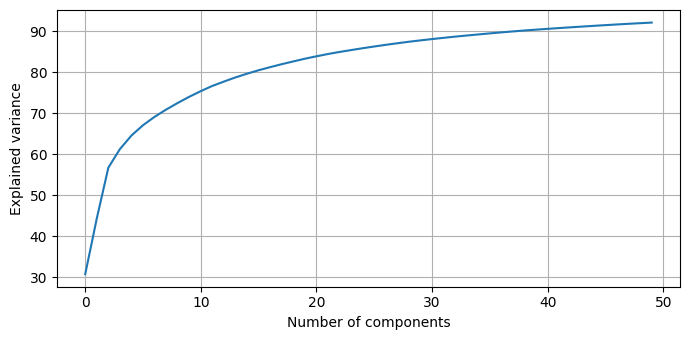

In [17]:
# Aribrtary number of dimensions, we will probably only want 2
pca = decomposition.PCA(n_components=50)

# Normalise pixels to be between 0-1 intensity
X_norm = [item/255 for item in X]

pca.fit(X_norm)

plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
print(f'The first 2 components account for {round(np.cumsum(pca.explained_variance_ratio_ * 100)[1], 1)}% of variation')
print(f'The first 10 components account for {round(np.cumsum(pca.explained_variance_ratio_ * 100)[9], 1)}% of variation')
plt.show()

### Obtain first two components for plotting
For ease of plotting, we truncate the principal components to the first two (x and y axes). As proven above, only 44% of the variation in the dataset is captured by these two dimensions, and as such, there is very little separation observed in the two classes. This indicates a potentially low predictive power of these features in a classification model. 

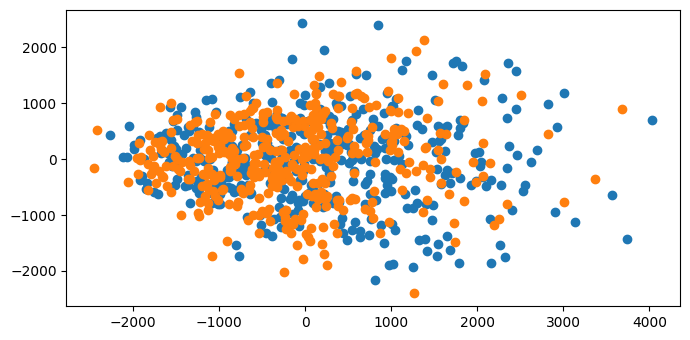

In [18]:
pc_2 = pca.fit_transform(X)[:, 0:2]
real_pc = pc_2[0:len(real)]
fake_pc = pc_2[len(real):]
plt.scatter(real_pc[:,0], real_pc[:, 1])
plt.scatter(fake_pc[:,0], fake_pc[:, 1])
plt.show()

## T-SNE
Similarly, T-SNE is used to examine whether two more visually accessible components can be deduced, again, with very little separation shown. This indicates that there is a lot of variation, and thus likely noise, contained within this dataset.

/Users/sarah/.local/share/virtualenvs/corneal-reflections-PSVv1w5v/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/sarah/.local/share/virtualenvs/corneal-reflections-PSVv1w5v/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 832 samples in 0.001s...
[t-SNE] Computed neighbors for 832 samples in 0.113s...
[t-SNE] Computed conditional probabilities for sample 832 / 832
[t-SNE] Mean sigma: 2.214920
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.432297
[t-SNE] KL divergence after 1000 iterations: 1.422543


[Text(0.5, 1.0, 'Iris images variation projection with T-SNE')]

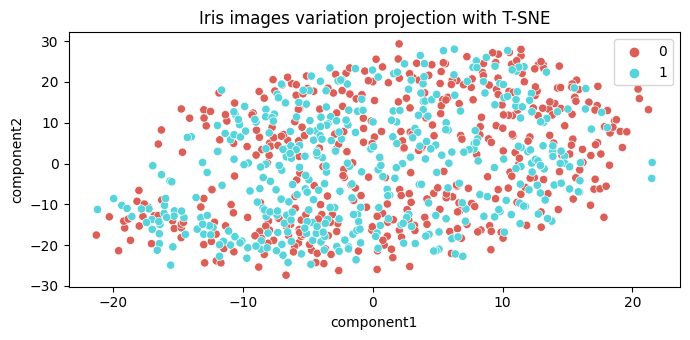

In [19]:
tsne = manifold.TSNE(n_components=2, verbose=1, random_state=4)
tsne_out = tsne.fit_transform(np.array(X_norm))

df = pd.DataFrame()
df["y"] = y
df["component1"] = tsne_out[:,0]
df["component2"] = tsne_out[:,1]

sns.scatterplot(x="component1", y="component2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 2),
                data=df).set(title="Iris images variation projection with T-SNE") 

## Feature Vectors
Combine all features into input dataframe with image IDs and real vs. fake labels.

In [20]:
# Add to features
feature_vectors['hog_px'] = hog_pixels
feature_vectors['specular_px'] = specular_pixels
feature_vectors['n_circles'] = n_circles
feature_vectors['edges'] = edges

feature_vectors['mean_intensity'] = intensities
feature_vectors['mean_r'] = reds
feature_vectors['mean_g'] = greens
feature_vectors['mean_b'] = blues

feature_vectors['pc1'] = pc_2[:,0]
feature_vectors['pc2'] = pc_2[:,1]

feature_vectors

,image_id,label,hog_px,specular_px,n_circles,edges,mean_intensity,mean_r,mean_g,mean_b,pc1,pc2
0,0,0,2116,78,1,292,85.090253,85.296029,77.081227,100.832130,3734.206954,-1426.893431
1,1,0,1296,0,0,176,43.017227,49.552912,37.704676,50.930271,-899.273767,203.513915
2,2,0,2304,11,0,246,90.593274,97.192853,87.862848,93.454545,1682.294269,-419.568563
3,3,0,1764,9,0,160,31.734603,59.313651,32.800635,19.145397,-1077.111718,-788.068211
4,4,0,1764,10,0,256,61.778246,76.835088,59.092632,61.256842,581.446177,-1122.471959
...,...,...,...,...,...,...,...,...,...,...,...,...
827,827,1,2500,11,0,259,66.327065,85.637367,65.182339,61.163532,32.323841,469.711037
828,828,1,2304,0,0,113,55.527725,74.909656,56.025813,47.139579,-71.707711,189.011779
829,829,1,2499,14,0,262,51.951603,77.620085,53.464610,39.176044,1028.291981,539.278570
830,830,1,3136,8,0,336,60.038541,76.269784,60.874615,52.154162,1564.183026,476.509733


## Feature Exploration across Dataset
Probability density plots (https://seaborn.pydata.org/generated/seaborn.kdeplot.html) are used to examine the relative probabilities of each feature ocurring within each input data class. Although the distributions exhibit similar shapes and variance, it can be noted that the fake image class are more dominant in the first principal component, and are less likely than the real images to contain detectable circular pupils or specular highlights. 

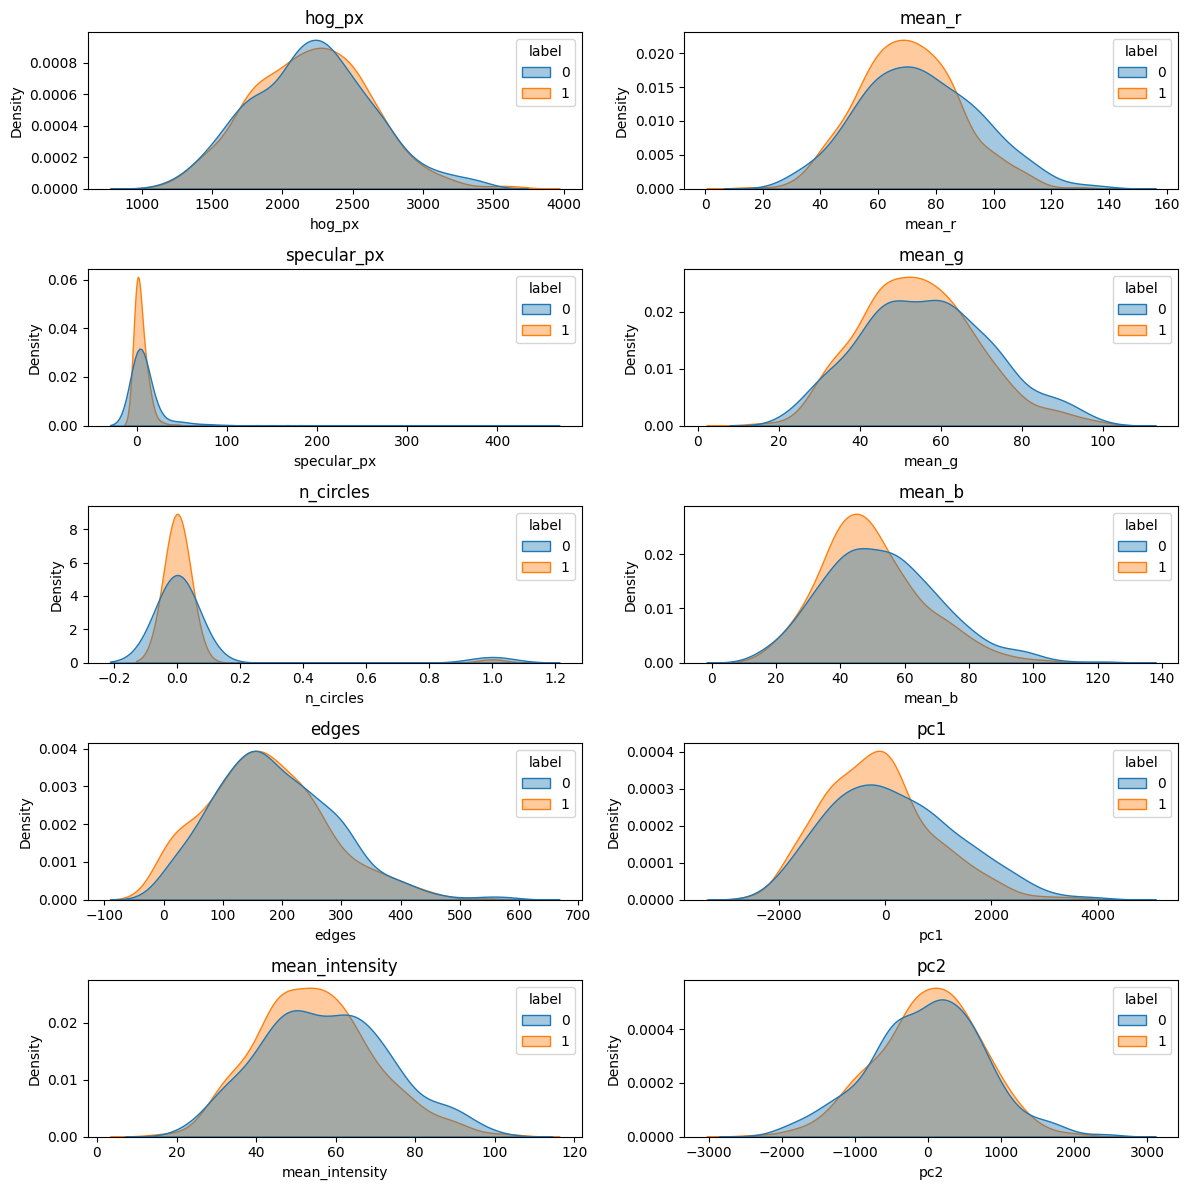

In [21]:
features = feature_vectors.columns[2:]

rows = 2
columns = 5

fig, axes = plt.subplots(columns, rows, figsize=(12, 12))

row = 0
col = 0

for i in range(len(features)):
    sns.kdeplot(data=feature_vectors, fill=True, x=features[i], hue = 'label', common_norm=False, alpha=0.4, ax=axes[col, row])
    axes[col, row].set_title(f'{features[i]}')
    col = col + 1
    if col == 5:
        row = row + 1
        col = 0
fig.tight_layout()

plt.show()

# Classifer Models

The data is randomly divided into 3 sections: training, testing and validation sets. 

Three classifer approaches are then used: firstly, a simple linear model (logistic regression) which performs only slightly better than chance (accuracy of 0.545 vs. 0.500). Secondly, a Support Vector Machine model of similar but poorer performance (0.515). Finally, the SVM model is tuned using a hyperparameter sweep on the validation set, that results in an accuracy increase of ~7%. This is achieved through tuning the C and gamma parameters. 

In [22]:
from sklearn.model_selection import train_test_split

# Set up train, test and validation sets
X = feature_vectors[feature_vectors.columns[2:]]
y = feature_vectors['label']

X_norm = preprocessing.normalize(X)

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=4)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=4)

## Model 1: Logistic Regression

In [23]:
logisticRegr = linear_model.LogisticRegression()
logisticRegr.fit(X_train, y_train)

score = logisticRegr.score(X_test, y_test)
print(score)

0.5449101796407185


## Model 2: 

In [24]:
clf = svm.SVC()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)

score = clf.score(X_test, y_test)
print(score)

0.5149700598802395


# Generalizability
Performing a grid search using the sklearn function gridsearchCV enables the optimisation of parameters. This occurs through testing out different values for the C and gamma parameters within the SVC model on different folds of the validation dataset, ensuring maximum generalisability and avoiding overfitting to the specific data within the training set. 

### Hyperparameter Sweep using Grid Search

In [25]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

grid = model_selection.GridSearchCV(svm.SVC(), param_grid, refit = True)
  
# fitting the model for grid search - fit on VALIDATION set
grid.fit(X_val, y_val)

# print best parameter after tuning
print(f'Best params: {grid.best_params_}')
print(f'Best estimator post-tuning: {grid.best_estimator_}')

score = grid.score(X_test, y_test)
print(score)

Best params: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best estimator post-tuning: SVC(C=10, gamma=1)
0.5808383233532934


## Model Performance & Discussion
Overall, even the best performing classifier model (hyperparameter-tuned SVC) yields an accuracy of <b>0.58</b> on the test sets. This is only a slight improvement on random chance, which is 0.5. With this low performance, it is difficult to analyse whether generalisability was achieved, however, this could be validated through increasing the sample size to the full 70,000 images. The training process could then be improved by encompassing a larger validation set to optimise the hyperparameters.  

### ROC Curve

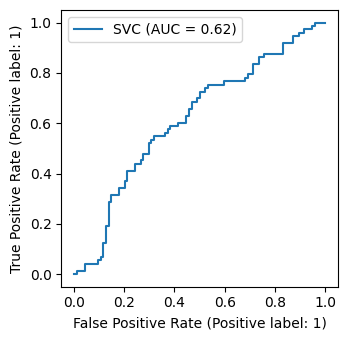

In [26]:
# prepare plots
clf.fit(X_train, y_train)
fig = plt.figure()
ax = fig.add_subplot()

metrics.RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax)

ax.set_aspect('equal', adjustable='box')

plt.legend()
plt.show()

## Accuracy vs. Precision and Recall
Reminder of encoding:
* 1 = fake image
* 0 = real image

Examining the precision and recall, in addition to accuracy, show us the classifier's performance in terms of false positives (a real image mis-classified as fake)  and true negatives (a fake image mis-classified as real). 

Precision: the proportion of positive identifications (pictures labelled as fake) that were correctly classified (actual fakes).

Recall: the proportion of true positives (fake images) that were correctly classifed (as fake).

We observe similar performances in both the precision (0.6) and recall (0.59) of the bst performing model.

In [27]:
grid_predictions = grid.predict(X_test)
print(metrics.classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.68      0.49      0.57        94
           1       0.52      0.70      0.59        73

    accuracy                           0.58       167
   macro avg       0.60      0.59      0.58       167
weighted avg       0.61      0.58      0.58       167



## Comparison of classification by category
Finally, in plotting the confusion matrix, we observe these relative performances by category. In particular, the classifer performs best in predicting true positives, with only 22 observations in the test set being mislabelled as a true negative. 48 real images were classified as fake (false postives).

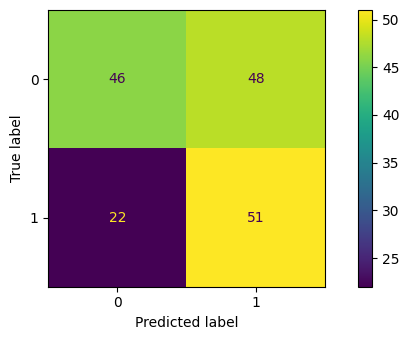

In [28]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, grid_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()